#### 다변량 다중시점 시계열 예측 Seq2Seq 


다변량 시계열 예측을 할 때 시퀀스 투 시퀀스(sequence to sequence, seq2seq) 형태를 사용하면 더 정교한 시계열 예측이 가능해진다.
Seq2Seq 모델은 주로 두 개의 LSTM으로 구성됨.
- 첫 번째 LSTM(인코더)은 입력 시퀀스를 고정 길이의 콘텍스트 벡터로 인코딩
- 두 번째 LSTM(디코더)은 이 벡터를 기반으로 출력 시퀀스를 생성한다. 이는 주로 번역, 대화 생성 및 시계열 예측에 사용된다. 

 
Seq2 Seq을 이용한 다중시점 시계열 예측의 가장 큰 장점은, known future input 값을 사용할 수 있다는 점이다.
Seq2 Seq의 Encoder 가 과거의 정보를 받아서 콘텍스트 벡터로 인코딩을 하고,
Decoder는 인코딩 된 콘텍스트 벡터에 known future input을 결합하여 예측을 수행하게 된다. 

<img src="multi-horizon.png" alt="multi-horizon" width="600">

예를 들어, 미래 τ 구간의 주식의 가격을 예측한다고 할 때, 우리는 예측 모델의 학습을 위해 입력값으로
1. 과거의 주식 가격 (y_t-k:t)
2. 과거의 정보만 알 수 있는 설명변수들. 예를 들어 거래량, 다른 주식의 가격정보 등 (x_t-k:t)
3. 뿐만 아니라 미래에도 알 수 있는 정보 (known future input). 예를들어 요일정보, 휴장일 정보 등(u_t-k:t+ τ)을 학습과 예측에 사용할 수 있는 것.

※ 이때 known future input 의 과적정보 (u_t-k:t)는 S2S의 Encoder의 입력값으로 사용되며, 미래정보 (u_t+1: t+ τ) 는 Decoder의 입력값으로 사용된다.  

In [1]:
import os
import random
import warnings
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch   # pip install keras-hypetune 으로 설치해야함. 



#### 데이터 생성 

In [2]:
df = pd.read_csv('crime.csv')
df.head(3)

,Unnamed: 0,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763


In [3]:
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])
df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df.head(3)

,n_crimes
2003-01-01,191
2003-01-02,148
2003-01-03,160


In [4]:
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day
df.head(3)

,n_crimes,month,wday,day
2003-01-01,191,1,2,1
2003-01-02,148,1,3,2
2003-01-03,160,1,4,3


#### 시계열 데이터를 슬라이딩 윈도우 형태로 변환해 주는 사용자 정의함수. 
- ① start_id 부터 end_id 인덱스 구간 내에서 ② window_shape을 윈도 사이즈로 ③ step 간격으로 추출
- 결과물은 3D 데이터 : (윈도우 개수, 윈도 사이즈, 피쳐 개수) 

In [5]:
def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):

    data = np.asarray(data)
    # np.prod 는 데이터의 shape 원소를 모두 곱함. ==max(data.shape) 이라는건 1차원인 경우 => 1차원 데이터만 2차원으로 바꿔주겠다..
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data

    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id

    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])  # (window_shape, feature개수)
    step = (int(step),) * data.ndim  # 데이터가 2차원이면 (1,1)
    slices = tuple(slice(None, None, st) for st in step)  # slice 는 [::] 와 동일, slice(first:end,step) = first 부터 end 까지 step 간격으로 추출하겠다.
    indexing_strides = data[slices].strides  # step이 1이기 때문에 data[slices] = data와 동일함. 
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1  # 전체 윈도우 인덱스의 shape (data 전체길이 - window size +1, 1)

    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))

    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    return np.squeeze(window_data, 1)

In [6]:
# 3D 데이터의 정규화와 원복시키는 클래스 생성
# (mean 과 std 인스턴스 와 transform ↔ inverse_trainsform 매써드 제공)

class Scaler3D:

    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)  # 피쳐 기준으로 평균구한 뒤 (1,1,n) 형태로 저장
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)   # 피쳐 기준으로 분산구한 뒤 (1,1,n) 형태로 저장
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse_transform(self, X):
        return (X * self.std) + self.mean

① 숫자형 타겟변수 , ② 혼합형 변수 (과거시점의 윈도 사이즈로 구분), ③ 혼합형 변수 (미래시점의 예측 구간으로 구분)을 딕셔너리 형태로 구분하여 저장 

In [7]:
target = ['n_crimes']
cat_var = ['month','wday','day']

# 학습용 데이터셋 만들기
def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):

    if scaler is not None:
        num_X = scaler.transform(num_X)  # X 입력데이터 중 타겟값은 정규화

    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]

    return inp_dict

- 앞선 3개의 사용자 지정함수 및 클래스를 이용하여, 최종적으로 Train, Valid 데이터셋을 생성한다. 
- 혼합형 변수인지, 숫자형 변수인지에 따라. 그리고 과거시점의 값인지 (Encoder의 인풋인지) 미래시점의 값인지 (Decoder의 인풋인지)를 구분하여 만든다.

In [12]:
### Split train & test, apply scaler

time_h = 7   # 예측하고자 하는 시점과의 시차
window_shape = 21  # 윈도우 사이즈 

# 시계열 데이터이기 때문에 shuffle 없이 앞에서부터 자름
_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)
print(_id_train, _id_valid)

[   0    1    2 ... 3693 3694 3695] [3696 3697 3698 ... 5278 5279 5280]


In [11]:
# _num 과 _target 은 각각 숫자형 타겟 데이터를 학습용과 타겟용으로 분리한것 
# _cat1 과 _cat2 는 각각 범주형 변수들을 윈도우사이즈, 예측구간으로 분리한것 

_num_X = create_windows(df[target], step =1, window_shape=window_shape, end_id=-time_h)  # 원본데이터 타겟값(범죄수)를 윈도우 데이터로 생성
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)  # 원본데이터 피쳐값(날짜정보를)를 앞에서부터 윈도우 데이터로 생성
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)  # 원본데이터 피쳐값(날짜정보를)를 윈도우사이즈+1 인덱스부터 예측시차 사이즈의 윈도우 데이터로 생성
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)  #  원본데이터 타겟값(범죄수)를 윈도우사이즈+1 인덱스부터 예측시차 사이즈의 윈도우 데이터로 생성

print(_num_X.shape , _cat1_X.shape, _cat2_X.shape, _target.shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

print(_num_X_train.shape, _cat1_X_train.shape, _cat2_X_train.shape, _target_train.shape)
print(_num_X_valid.shape, _cat1_X_valid.shape, _cat2_X_valid.shape, _target_valid.shape)

(5281, 21, 1) (5281, 21, 3) (5281, 7, 3) (5281, 7, 1)
(3696, 21, 1) (3696, 21, 3) (3696, 7, 3) (3696, 7, 1)
(1585, 21, 1) (1585, 21, 3) (1585, 7, 3) (1585, 7, 1)


In [ ]:
X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

print(X_scaler.mean, X_scaler.std)
print('----------------------\n\n')

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

print(X_train['inp_num'].shape)  # 예측에 사용할 과거 시점의 윈도사이즈 타겟변수 
print(X_train['inp_month_cat1'].shape, X_train['inp_wday_cat1'].shape, X_train['inp_day_cat1'].shape) # 예측에 사용할 과거 시점의 윈도사이즈 피쳐
print(X_train['inp_month_cat2'].shape, X_train['inp_wday_cat2'].shape, X_train['inp_day_cat2'].shape) # 예측에 사용할 미래 시점의 예측 시차 크기의 피쳐
print(y_train.shape) # 예측값과 비교할 실제 값 

[[[103.11648371]]] [[[28.79297087]]]
----------------------


(3696, 21, 1)
(3696, 21) (3696, 21) (3696, 21)
(3696, 7) (3696, 7) (3696, 7)
(3696, 7, 1)


#### Seq2 Seq 모델 생성 및 학습 (교차검증)

- LSTM 기반의 Encoder와 Decoder로 구성된 Seq2 Seq 모델 생성 

In [18]:
### Define Model

def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):   # 여기서 param 은 KerasGridSearch 에서 param_grid 딕셔너리로 입력됨

    set_seed(33)

    # Input 레이어는 모델의 입력을 정의. shape 에는 배치크기를 제외한 입력 데이터의 형태, name 에는 입력 레이어의 이름
    # name 에 입력된 값은 실제 입력 데이터 이름 (X_train 딕셔너리의 키값)과 일치해야함
    inp_num = Input((window_shape,1), name='inp_num')

    # month, wday, day와 같은 카테고리형 변수들에 대한 임베딩 레이어 정의
    # Embedding (input_dim, output_dim) 레이어는 카테코리형 데이터를 고차원 데이터로 변환해준다.
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }

    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")   # (window_shape,) 형태의 입력 레이어 생성
        emb = embeddings[c](_inp_c1)   # c 에 해당하는 변수의 임베딩 레이어를 _inp_c1 적용
        inp_cat1.append(_inp_c1)  # inp_cat1 에는 임베딩하기전의 카테고리형 변수를 넣음
        emb_cat.append(emb)    # emb_cat 에는 임베딩 이후 카테고리형 변수를 넣음

    enc = Concatenate()([inp_num] + emb_cat)
    # 숫자형 입력과 임베딩된 카테코리형 입력을 연결. 이때 input_num 은 (batch_size, window_shape, 1) // emb_cat 은 (batch_size, window_shape, emb_dim)
    # 두개를 연결하고난 뒤 enc 의 shape 은 (batch_size, window_shape, total_features), ※ total_features = 1 + len(cat_var) * emb_dim
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)
    # LSTM 레이어를 concat된 입력 (batch_size, window_shape, total_features)에 적용
    # LSTM 레이어를 적용한뒤 출력된 enc 의 형태는 (batch_size, lstm_units)


    inp_cat2, emb_future = [], []    # 위에 for 문과 동일하게, (time_h,) 형태의 카테코리형 변수의 임베딩 전/후 상태를 리스트에 각각 저장
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb)  # emb_future 의 shape 은 (batch_size, time_h, emb_dim)

    x = RepeatVector(time_h)(enc)  # x 는 enc 를 time_h 만큼 반복하라는 의미 => x 의 shape 은 (batch_size, time_h, lstm_units)
    dec = Concatenate()([x] + emb_future)  # dec 의 shape 은 (batch_size, time_h, lstm_units + len(cat_var) * emb_dim)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)
    # return_sequences=True 이기 때문에 각 타임스텝에 대한 출력을 반환 => 출력 후 dec 의 shape 은 (batch_size, time_h, lstm_units)

    # TimeDistributed 레이어는 ()안에 주어진 레이어를 입력의 각 타임 스텝에 독립적으로 적용
    # 디코더 출력 dec 의 각 타임스텝에 Dense 레이어를 적용 => output 의 shape 은 (batch_size, time_h, 1)
    # Dense layer 에 activation 파라미터 추가 가능, 디폴트는 activation=None
    output = TimeDistributed(Dense(1))(dec)

    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(lr=param['lr']), 'mse')

    return model

In [19]:
## Modeling Fitting

param_grid = {
    'lstm_unit': [128,64,32],
    'emb_dim': [8,16,32],
    'lr': [1e-3,1e-2], ## learning rate
    'epochs': 10,
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])

print('BEST PARAM:', kgs.best_params)


18 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')



***** (1/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22043 at epoch 3



***** (2/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22043 at epoch 3



***** (3/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22035 at epoch 2



***** (4/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22035 at epoch 2



***** (5/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22026 at epoch 6



***** (6/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22026 at epoch 6



***** (7/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22023 at epoch 4



***** (8/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22023 at epoch 4



***** (9/18) *****
Search({'lstm_unit': 32, 'emb_dim': 16, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.2214 at epoch 10



***** (10/18) *****
Search({'lstm_unit': 32, 'emb_dim': 16, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.2214 at epoch 10



***** (11/18) *****
Search({'lstm_unit': 32, 'emb_dim': 32, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22272 at epoch 6



***** (12/18) *****
Search({'lstm_unit': 32, 'emb_dim': 32, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.22272 at epoch 6



***** (13/18) *****
Search({'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21898 at epoch 3



***** (14/18) *****
Search({'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21898 at epoch 3



***** (15/18) *****
Search({'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21873 at epoch 10



***** (16/18) *****
Search({'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21873 at epoch 10



***** (17/18) *****
Search({'lstm_unit': 64, 'emb_dim': 32, 'lr': 0.01, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21979 at epoch 8



***** (18/18) *****
Search({'lstm_unit': 64, 'emb_dim': 32, 'lr': 0.001, 'epochs': 10, 'batch_size': 64})
SCORE: 0.21979 at epoch 8
BEST PARAM: {'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.01, 'epochs': 10, 'batch_size': 64, 'steps_per_epoch': 58}


50/50 [==============================] - 0s 4ms/step
(1585, 7, 1) (1585, 7) (1585, 7)


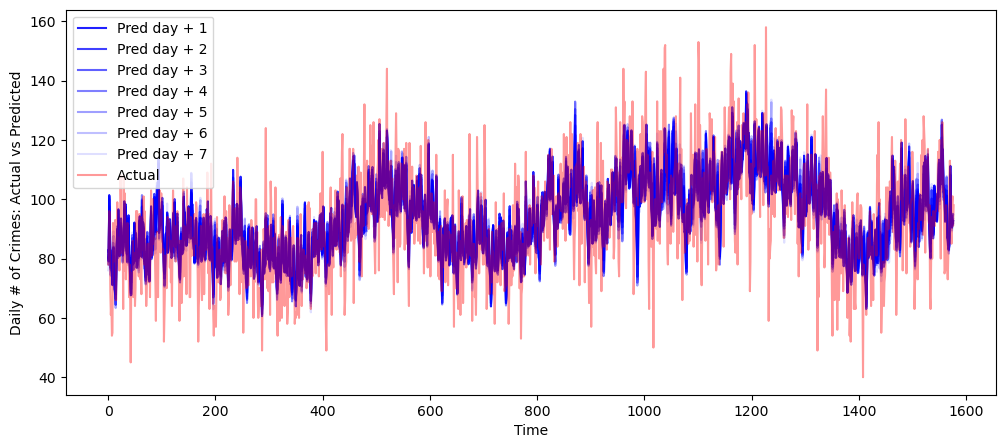

In [20]:
## Get predicted values

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

print(kgs.best_model.predict(X_valid).shape, pred.shape, y_valid.shape)

## Visualize Test vs Predicted
## Test vs prediction values are on different time horizons

plt.figure(figsize=(12,5))

for t_h in range(time_h):
    plt.plot(pred[(time_h - t_h):-(t_h+1),t_h],
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"Pred day + {t_h+1}")

# t_h 가 0 이면, 각 예측 윈도우 중에서 첫번째 값들을 사용 // 2 이면 각 예측 윈도우 중에서 3번째 값들을 사용

plt.plot(y_valid[time_h:,0], c='red', alpha=0.4, label='Actual')

plt.ylabel('Daily # of Crimes: Actual vs Predicted')
plt.xlabel('Time')
plt.legend()
plt.show()